### Prototype Goal


By using Streamlit I developed an interactive platform where users can search for air fryer models and receive detailed information about their current air fryer, including price, total score, power consumption, and energy label. If the selected air fryer is already highly energy-efficient (A++, A+, or A), the platform informs users that there is no need to replace it. For less efficient models, it provides recommendations for air fryers with higher total scores, lower power consumption, and lower prices, along with tags explaining why these recommendations are better. The platform also calculates the payback period and monthly savings after the payback period, helping users understand the financial benefits of switching to a more efficient model. Additionally, it highlights extra features in the recommendations, such as being dishwasher safe or having a transparent lid, if the selected air fryer lacks these features.

### Scraping from Bol.com

I set up a Chrome browser instance using Selenium to automate web scraping tasks. I used Google Translate to translate the entire web page to English. For the first webpage, I handled any initial consent or cookie acceptance buttons to ensure interaction with the page content. I scrolled the page to load all dynamic content, such as images, specifications, and reviews. I then scraped key product details like the model name, price, image, and specifications. I continuously clicked the 'Show More' button for reviews until all were loaded, then collected all available reviews, including pros and cons. To prevent the process from getting stuck, I implemented a timeout mechanism that closes the browser and moves to the next URL if scraping takes more than 5 minutes. I processed multiple URLs, saving the scraped data into separate CSV files every 10 URLs for efficient data management. For each URL, the script followed this structured process to gather all necessary information accurately.


In [ ]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from selenium.common.exceptions import NoSuchElementException, TimeoutException, ElementClickInterceptedException
import time
import logging
import threading

# Setup logging
logging.basicConfig(filename='scraping_errors.log', level=logging.ERROR, format='%(asctime)s:%(levelname)s:%(message)s')

def setup_driver():
    driver_path = 'C:\\chromedriver-win64\\chromedriver.exe'
    service = Service(executable_path=driver_path)
    driver = webdriver.Chrome(service=service)
    return driver

def handle_initial_buttons(driver):
    try:
        WebDriverWait(driver, 20).until(
            EC.element_to_be_clickable((By.ID, 'js-first-screen-accept-all-button'))).click()
        WebDriverWait(driver, 20).until(
            EC.element_to_be_clickable((By.CLASS_NAME, 'js-country-language-btn'))).click()
    except TimeoutException:
        logging.error("Initial buttons not found or timeout at URL: " + driver.current_url)

def slow_scroll(driver, steps, delay):
    for step in range(steps):
        driver.execute_script(f"window.scrollBy(0, {step * 10});")  # Scroll 10 pixels at a time for faster scroll
        time.sleep(delay)

def click_show_more(driver, selector):
    try:
        show_more_button = WebDriverWait(driver, 20).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, selector)))
        driver.execute_script("arguments[0].scrollIntoView();", show_more_button)
        time.sleep(1)  # Give some time for the scrolling
        show_more_button.click()
        time.sleep(2)
    except ElementClickInterceptedException:
        logging.error(f"Element click intercepted for selector '{selector}' at URL: " + driver.current_url)
        driver.execute_script("arguments[0].click();", show_more_button)
    except TimeoutException:
        logging.error(f"Show More button with selector '{selector}' not found or timed out at URL: " + driver.current_url)
        raise  # Reraise the exception to handle it outside the function

def extract_data(driver, url):
    driver.get(url)
    handle_initial_buttons(driver)
    slow_scroll(driver, 50, 0.1)  # Faster scroll to bottom
    
    data = {}
    
    # Extract model
    try:
        model = WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "span[data-test='title']"))).text
        data['Model'] = model
    except (NoSuchElementException, TimeoutException) as e:
        logging.error(f"Model element not found at URL: {url}")
        data['Model'] = "Not Found"

    # Extract price
    try:
        price = WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "span.promo-price[data-test='price']"))).text
        data['Price'] = price
    except (NoSuchElementException, TimeoutException) as e:
        logging.error(f"Price element not found at URL: {url}")
        data['Price'] = "Not Found"

    # Extract image
    try:
        image = WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "img#image-zoom-modal-selected-image"))).get_attribute("src")
        data['Image'] = image
    except (NoSuchElementException, TimeoutException) as e:
        logging.error(f"Image element not found at URL: {url}")
        data['Image'] = "Not Found"

    # Click and extract specifications
    specifications = []
    try:
        show_more_button_selector = "#mainContent > div > div.constrain.u-pb--m > div.\\[.fluid-grid.fluid-grid--rwd--l.\\].new_productpage > div:nth-child(1) > section.slot.slot--seperated.slot--seperated--has-more-content.js_slot-specifications > div > div > div.show-more__fade.js_show-more-button > a.ui-btn.ui-btn--secondary.show-more-button.js_link-more"
        click_show_more(driver, show_more_button_selector)

        specifications_selector = "#mainContent > div > div.constrain.u-pb--m > div.\\[.fluid-grid.fluid-grid--rwd--l.\\].new_productpage > div:nth-child(1) > section.slot.slot--seperated.slot--seperated--has-more-content.js_slot-specifications > div > div > div.js_show-more-holder.show-more-holder.show-more--l.product-specifications-show-more.product-tracklists-show-more--animate > div"
        specifications_holder = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, specifications_selector)))

        spec_titles = specifications_holder.find_elements(By.TAG_NAME, "dt")
        spec_values = specifications_holder.find_elements(By.TAG_NAME, "dd")

        for title, value in zip(spec_titles, spec_values):
            specifications.append((title.text, value.text))
        
        data['Specifications'] = specifications
    except (NoSuchElementException, TimeoutException) as e:
        logging.error(f"Specifications element not found at URL: {url}")
        data['Specifications'] = "Not Found"

    # Scroll to reviews
    slow_scroll(driver, 50, 0.1)

    # Extract review score
    try:
        review_score = WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "div[data-test='rating-suffix']"))).text
        data['Review Score'] = review_score
    except (NoSuchElementException, TimeoutException) as e:
        logging.error(f"Review Score element not found at URL: {url}")
        data['Review Score'] = "Not Found"
    
    # Click "Show More" button for reviews until all are loaded
    show_more_reviews_selector = "button#show-more-reviews"
    while True:
        try:
            click_show_more(driver, show_more_reviews_selector)
            slow_scroll(driver, 10, 0.1)
        except TimeoutException:
            break  # Exit loop if no more "Show More" button to load

    # Scrape reviews
    reviews = []
    try:
        review_elements = WebDriverWait(driver, 20).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, '[data-test="review-list"] li')))
        for review_element in review_elements:
            review_text = review_element.text

            # Extract pros and cons
            try:
                pros = review_element.find_element(By.CSS_SELECTOR, '[data-test="review-pros"]').text
                cons = review_element.find_element(By.CSS_SELECTOR, '[data-test="review-cons"]').text
            except NoSuchElementException:
                pros = "No pros listed"
                cons = "No cons listed"

            review_data = {
                'review_text': review_text,
                'pros': pros,
                'cons': cons
            }
            reviews.append(review_data)
    except (NoSuchElementException, TimeoutException) as e:
        logging.error(f"Review elements not found at URL: {url}")
        reviews = [{"review_text": "Not Found", "pros": "Not Found", "cons": "Not Found"}]

    data['Reviews'] = reviews if reviews else "Not Found"
    data['Link'] = url

    return data

def scrape_urls(urls):
    all_data = []
    batch_number = 49  # Start batch number from 49
    for i, url in enumerate(urls):
        data = scrape_with_timeout(url)
        all_data.append(data)
        time.sleep(5)  # Wait for 5 seconds before scraping the next URL
        if (i + 1) % 10 == 0 or (i + 1) == len(urls):  # Save every 10 URLs or at the end
            save_to_csv(all_data, batch_number)
            batch_number += 1
            all_data = []  # Reset all_data for the next batch

def scrape_with_timeout(url):
    driver = setup_driver()
    data = {}
    def scrape():
        nonlocal data
        try:
            data = extract_data(driver, url)
        except Exception as e:
            logging.error(f"Error scraping URL: {url} - {str(e)}")
        finally:
            driver.quit()

    scrape_thread = threading.Thread(target=scrape)
    scrape_thread.start()
    scrape_thread.join(timeout=300)  # 5 minutes timeout

    if scrape_thread.is_alive():
        logging.error(f"Timeout exceeded for URL: {url}")
        driver.quit()
        scrape_thread.join()

    return data

def save_to_csv(data, batch_number):
    columns = ["Model", "Price", "Image", "Specifications", "Review Score", "Reviews", "Link"]
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(f'all_products_batch_{batch_number}.csv', index=False)
    print(f"Saved batch {batch_number} to CSV")

# URLs to scrape
urls = []

# Scrape data
scrape_urls(urls)


### Cleaning the data

In my project, I needed to clean and structure a dataset containing specifications of various products, which were stored as lists of tuples in a single column. Some tuples were problematic and caused errors during parsing. To resolve this, I followed a systematic approach:

First, I loaded the dataset and identified the problematic tuples, which included those with errors or irrelevant keys such as 'Important options' and 'Categories'. I then created a new column where I stored only the valid tuples, effectively filtering out any problematic data.

Next, I converted these cleaned tuples into dictionaries for easier access and manipulation of the data. This ensured that each row had a structured dictionary of valid specifications, which could then be used for further analysis.

Finally, I saved the cleaned and structured data into a new CSV file, allowing for a more efficient and error-free data analysis process.

In [ ]:
import pandas as pd
import ast

# Load the CSV data into a DataFrame
df = pd.read_csv(r'C:\A+ Appliance Recommender\translated_products.csv')

# Function to clean and filter the 'Specifications' column
def clean_tuples(specs):
    if pd.isna(specs):
        return []
    try:
        # Safely evaluate string representation of list of tuples
        specs_list = ast.literal_eval(specs)
        clean_list = []
        for tup in specs_list:
            try:
                if len(tup) == 2 and isinstance(tup[0], str) and isinstance(tup[1], str):
                    key = tup[0].strip()
                    value = tup[1].strip()
                    if not any(k in key for k in ('Important options', 'Categories')):
                        clean_list.append((key, value))
            except (ValueError, SyntaxError):
                print(f"Error parsing tuple: {tup}")
        return clean_list
    except (ValueError, SyntaxError) as e:
        print(f"Error parsing specifications: {specs}. Error: {e}")
        return []

# Apply the function to the 'Specifications' column and create a new column 'Clean_tuples'
df['Clean_tuples'] = df['Specifications'].apply(clean_tuples)

# Function to convert clean tuples into a dictionary
def tuples_to_dict(tuples):
    try:
        return {k: v for k, v in tuples}
    except Exception as e:
        print(f"Error converting tuples to dict: {tuples}. Error: {e}")
        return {}

# Convert 'Clean_tuples' into dictionaries and store in a new column 'Specifications_dict'
df['Specifications_dict'] = df['Clean_tuples'].apply(tuples_to_dict)

# Display the resulting DataFrame with the new 'Clean_tuples' and 'Specifications_dict' columns
print(df[['Specifications', 'Clean_tuples', 'Specifications_dict']].head())

# Save the resulting DataFrame to a new CSV file to inspect the conversion
df.to_csv(r'C:\A+ Appliance Recommender\Final_with_clean_tuples.csv', index=False)


In [ ]:
import pandas as pd
import ast

df = pd.read_csv(r'C:\A+ Appliance Recommender\Final_with_reviews.csv')
# Drop rows with NaN values in the 'Model' column
df = df.dropna(subset=['Model'])

# List of Dutch specifications and their English equivalents
dutch_specs = [
    'Indicatie afgerond',
    'Warmhoud functionaliteit',
    'Automatisch uitschakelen',
    'Automatisch kookprogramma',
    'Maximale temperatuur',
    'Vermogen',
    'Bodem met antislip',
    'Met maatverdeling',
    'Doorzichtige deksel',
    'Temperatuur indicator',
    'Temperatuur instellingen',
    "Aantal programma's",
    'Snoerlengte',
    'Product gewicht',
    'Geschikt voor hoeveel frites',
    'Inhoud',
    'Geteste baktijd friet',
    'Geteste bakcapaciteit friet',
    'Switch on timer',
    'Timer',
    'Verwijderbare kom',
    'Vaatwasser veilig',
    'Cool wall',
    'Koord opslagruimte',
    'Indicatielampje',
    'Waarschuwingssignaal',
    'Antikleeflaag',
    'BPA-vrij',
    'Bediening via mobiele app',
    'Bestuurbaar via app',
    'Fabrieksgarantie termijn',
    'Introductie',
    'Kan zelfstandig met internet verbinden',
    'Opwarmfunctie',
    'Overhittingsbeveiliging',
    'PFAS-vrij',
    'Geschikt voor aantal personen',
    'Optimale bakcapaciteit'
]

english_specs = [
    'Indication completed',
    'Keep warm functionality',
    'Automatic switch-off',
    'Automatic cooking program',
    'Maximum temperature',
    'Power',
    'Non-slip bottom',
    'With graduation',
    'Transparent lid',
    'Temperature indicator',
    'Temperature settings',
    'Number of programs',
    'Cord length',
    'Product weight',
    'Suitable for how many fries',
    'Contents',
    'Tested baking time fries',
    'Tested baking capacity fries',
    'Switch on timer',
    'Timer',
    'Removable bowl',
    'Dishwasher safe',
    'Cool wall',
    'Cord storage space',
    'Indicator light',
    'Warning signal',
    'Non-stick coating',
    'BPA-free',
    'Control via mobile app',
    'Controllable via app',
    'Factory warranty term',
    'Introduction',
    'Can connect to the internet independently',
    'Warm-up function',
    'Overheat protection',
    'PFAS-free',
    'Suitable for number of people',
    'Optimal baking capacity'
]

# Rename the columns in df from Dutch to English
df = df.rename(columns=dict(zip(dutch_specs, english_specs)))



# Move the Reviews column to the end
reviews_col = df.pop('Reviews')
df['Reviews'] = reviews_col

# Display the resulting DataFrame
print(df.head())

# Save the resulting DataFrame to a new CSV file
df.to_csv(r'C:\A+ Appliance Recommender\Final_eng.csv', index=False)


### Scoring System and its recaliberation

 After converting non-numeric to numeric where needed, I  created a scoring system for both numeric and string columns, where numeric scores were based on value relevance and string scores on the presence of features, each normalized to ensure that the total didn't exceed 5 points from either category. After calculating a 'Final Score' that combined both types of scores for each model, I cleaned the DataFrame by removing intermediate score columns and finally exported the processed data, keeping only the most relevant columns for further analysis and decision-making.



##### Numeric weights

In [ ]:
import pandas as pd
import numpy as np

# Load the cleaned CSV data into a DataFrame
df = pd.read_csv(r'C:\A+ Appliance Recommender\Cleaned_for_Scoring.csv')

# Identify the numeric columns, excluding 'Power', 'Review Score', and 'Price'
excluded_columns = ['Power', 'Review Score', 'Price']
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_columns = [col for col in numeric_columns if col not in excluded_columns]

# Adjust the 'Introduction' column to set values out of range (2015, 2025) to zero
df['Introduction'] = df['Introduction'].apply(lambda x: x if 2015 <= x <= 2025 else 0)

# Initialize a dictionary to hold the max and min values for each column
min_max_values = {}

# Compute the max and min for each numeric column, with adjustments
for column in numeric_columns:
    non_zero_values = df[column][df[column] != 0]
    min_value = non_zero_values.min()
    max_value = non_zero_values.max()
    if column == 'Introduction' and min_value < 2015:
        min_value = 2015
    min_max_values[column] = {'min': min_value, 'max': max_value}

# Function to calculate the score based on a scale of 5
def calculate_score(value, min_value, max_value, reverse=False):
    if pd.isna(value) or value == 0:
        return np.nan
    if reverse:
        score = 5 * (max_value - value) / (max_value - min_value)
    else:
        score = 5 * (value - min_value) / (max_value - min_value)
    return round(score, 3)

# Create a new DataFrame to hold columns in the desired order
new_df = pd.DataFrame()

# Apply the scoring function to each numeric column and insert the score column next to the original
score_columns = []
for column in df.columns:
    new_df[column] = df[column]
    if column in numeric_columns:
        min_value = min_max_values[column]['min']
        max_value = min_max_values[column]['max']
        reverse = column in ['Product weight', 'Tested baking time fries']
        score_column = df[column].apply(calculate_score, args=(min_value, max_value, reverse))
        score_column_name = column + '_score'
        new_df.insert(new_df.columns.get_loc(column) + 1, score_column_name, score_column)
        score_columns.append(score_column_name)

# Calculate the Total numeric score as the average of the score columns excluding zeros and NaNs
def calculate_total_score(row):
    valid_scores = [score for score in row if pd.notna(score) and score != 0]
    if valid_scores:
        return round(np.mean(valid_scores), 3)
    return np.nan

new_df['Total numeric score'] = new_df[score_columns].apply(calculate_total_score, axis=1)

# Display the first few rows of the DataFrame with scores
print(new_df.head())

# Do not save the DataFrame to CSV yet
new_df.to_csv(r'C:\A+ Appliance Recommender\Scored_Data_numeric.csv', index=False)


##### String weights

In [ ]:
import pandas as pd
import numpy as np

# Load the CSV data into a DataFrame
df = pd.read_csv('C:\\A+ Appliance Recommender\\Scored_Data_numeric.csv')

# Define the string columns
string_columns = [
    'Indication completed', 'Keep warm functionality', 'Automatic switch-off', 'Automatic cooking program', 
    'Non-slip bottom', 'With graduation', 'Transparent lid', 
    'Temperature indicator', 'Temperature settings', 'Switch on timer', 'Timer', 'Removable bowl', 
    'Dishwasher safe', 'Cool wall', 'Cord storage space', 'Indicator light', 'Warning signal', 
    'Non-stick coating', 'BPA-free', 'Controllable via app',
    'Can connect to the internet independently', 'Warm-up function', 'Overheat protection', 'PFAS-free'
]

# Calculate the score per 'ja' response
score_per_ja = round(5 / len(string_columns), 3)

# Function to score string columns
def score_string_column(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, str) and value.lower() == 'ja':
        return score_per_ja
    return 0

# Apply scoring to string columns and calculate 'Total string score'
df['Total string score'] = 0
for column in string_columns:
    score_col = f'{column}_score'
    df[score_col] = df[column].apply(score_string_column)
    df[score_col] = df[score_col].round(3)  # Ensure 3 decimal places
    df['Total string score'] += df[score_col].fillna(0)  # Use fillna(0) to handle NaN in summation

# Ensure 'Total string score' is rounded to 3 decimal places
df['Total string score'] = df['Total string score'].round(3)

# Calculate 'Total Score' as the sum of 'Total string score' and 'Total numeric score'
df['Total Score'] = df['Total string score'] + df['Total numeric score']

# Ensure 'Total Score' is rounded to 3 decimal places
df['Total Score'] = df['Total Score'].round(3)

# Place 'Total Score' and 'Total string score' after 'Model' column
df.insert(df.columns.get_loc('Model') + 1, 'Total Score', df.pop('Total Score'))
df.insert(df.columns.get_loc('Model') + 2, 'Total string score', df.pop('Total string score'))

# Reorder columns to place _score columns next to their originals
columns_order = []
for column in df.columns:
    if column in string_columns:
        columns_order.append(column)
        columns_order.append(f'{column}_score')
    elif column not in [f'{col}_score' for col in string_columns]:
        columns_order.append(column)

df = df[columns_order]

# Save the final DataFrame to a new CSV file
df.to_csv('C:\\A+ Appliance Recommender\\scored_data_strings_Numeric_noweight.csv', index=False)

# Display the DataFrame with 'Total string score' to verify
print(df[['Model', 'Total string score', 'Total numeric score', 'Total Score']].head())


#### Calculating weights for all the columns with spacy based on reviews (recaliberation)

 In my process of refining the appliance recommendation platform, I aimed to enhance the accuracy and relevance of appliance suggestions by integrating user feedback and weight-based scoring. I began by gathering user reviews and extracting key specifications of various appliances. Then, I used a set of predefined weights to evaluate the importance of each specification, ensuring that the most crucial factors had a greater influence on the overall score. By removing any biases, such as assigning default weights incorrectly, I recalibrated the scoring system to reflect true user preferences.

In [ ]:
import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Load the CSV file
file_path = 'scored_data_strings_Numeric_noweight.csv'
data = pd.read_csv(file_path)

# List of specifications and synonyms
specifications = {
    "Indication completed": ["completion signal", "ready signal", "done signal"],
    "Keep warm functionality": ["keep warm", "stay warm",],
    "Automatic switch-off": ["auto shut-off", "power-off function", "auto power-off",],
    "Automatic cooking program": ["pre-set cooking mode", "smart cooking", "auto-cook"],
    "Maximum temperature": ["peak temperature", "highest temperature", "max temperature", "maximum heat"],
    "Power": ["energy consumption", "wattage", "electricity usage", "power consumption", "power"],
    "Non-slip bottom": ["anti-skid", "slip-resistant", "slip", "skid", "non-slip",],
    "With graduation": ["measurement markings", "graduated scale", "scale"],
    "Transparent lid": ["clear cover", "see-through lid", "glass lid", "transparent", "see-through"],
    "Temperature indicator": ["heat indicator", "temperature display", "temperature gauge", "temperature sensor"],
    "Temperature settings": ["heat settings", "temperature control", "heat control", "temperature adjustment"],
    "Number of programs": ["programs", "cooking presets", "cooking modes", "cooking programs", "modes"],
    "Cord length": ["cable length", "power cord length", "cord", "cable", "length", "long", "short"],
    "Product weight": ["item weight", "appliance weight", "airfryer weight", "weight", "heavy", "light"],
    "Suitable for how many fries": ["fry capacity", "number of fries capacity", "fries",],
    "Contents": ["volume", "capacity", "big", "small", "spacious", "compact", "roomy"],
    "Tested baking time fries": ["fry cooking time", "baking duration", "baking time", "cooking time"],
    "Tested baking capacity fries": ["frying volume", "baking capacity for fries", "fry capacity", "fries capacity"],
    "Switch on timer": ["start delay timer", "activation timer", "delay timer"],
    "Timer": [  "time", "clock", "countdown", "stopwatch", "timer"],
    "Removable bowl": ["detachable bowl", "removable basket", "removable tray", "removable", "detachable"],
    "Dishwasher safe": ["dishwasher friendly", "machine washable parts", "dishwasher", "wash", "clean", "cleaning", "washable", "washable parts"],
    "Cool wall": ["cool-touch", "insulated wall", "insulated",],
    "Cord storage space": ["cable storage", "cord compartment", "cord storage", "cable storage", "cord holder", "cable holder"],
    "Indicator light": ["signal light", "notification light", "light", "indicator", "signal"],
    "Warning signal": ["alert signal", "alarm signal", "alarm", "warning", "alert"],
    "Non-stick coating": ["non-stick surface", "anti-stick coating", "anti-stick", "non-stick", "sticks", "stick", "sticking", "non-sticking", "non-sticking surface", "anti-sticking", "anti-sticking surface", "anti-sticking coating"],
    "BPA-free": ["bisphenol-a free", "chemical-free", "non-toxic", "BPA"],
    "Controllable via app": ["phone", "app", "mobile", "smartphone", "smart", "control"],
    "Factory warranty term": ["manufacturer warranty period", "warranty duration", "warranty"],
    "Introduction": ["release date", "production date", "new"],
    "Can connect to the internet independently": ["internet", "Connectivity", "connect" ],
    "Warm-up function": ["preheat function", "heat-up feature", "warm-up", "preheat", "heat-up", "heat-up function"],
    "Overheat protection": [ "overheat"],
    "PFAS-free": [ "PFAS"]
}

# Function to preprocess text
def preprocess_text(text):
    doc = nlp(text.lower())
    return ' '.join([token.lemma_ for token in doc if token.is_alpha])

# Initialize the TF-IDF Vectorizer with the list of specifications and their synonyms as vocabulary
vocabulary = [term for spec in specifications for term in [spec] + specifications[spec]]
vectorizer = TfidfVectorizer(vocabulary=vocabulary)

# Initialize an empty DataFrame to accumulate the results
accumulated_tfidf = pd.DataFrame(columns=vocabulary)

# Process each review row by row
for index, row in data.iterrows():
    processed_review = preprocess_text(row['Reviews'])
    tfidf_matrix = vectorizer.fit_transform([processed_review])
    
    # Convert to DataFrame
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=[index])
    
    # Accumulate the results
    accumulated_tfidf = pd.concat([accumulated_tfidf, tfidf_df])
    
    # Save intermediate results to a file
    accumulated_tfidf.to_csv('accumulated_tfidf.csv', index=False)

print("Final TF-IDF Scores:\n", accumulated_tfidf)


#### Calculating score for numeric by regression model (recaliberation)

 I identified and selected the relevant numeric columns while excluding specific ones I didn't need. Then, I filtered out any rows with missing values in the selected numeric columns or the 'Review Score' to ensure completeness. I standardized the numeric data for consistency and used a linear regression model to understand the relationship between these numeric columns and the 'Review Score'. From the trained model, I extracted and normalized the importance of each numeric feature, assigning weights that sum to 1, indicating their relative importance. Finally, I compiled these weights into an easy-to-interpret format for further analysis.

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Load the cleaned CSV data into a DataFrame
df = pd.read_csv(r'scored_data_strings_Numeric_noweight.csv')

# Specify the numeric columns of interest
numeric_columns = [
    'Maximum temperature', 'Number of programs', 'Cord length', 'Product weight', 
    'Suitable for how many fries', 'Contents', 'Tested baking time fries', 
    'Factory warranty term', 'Introduction'
]

# Add 'Review Score' to the list of columns to ensure it's present in the DataFrame
columns_of_interest = numeric_columns + ['Review Score']

# Select only the columns of interest and drop rows with NaN values in any of these columns
df_selected = df[columns_of_interest].dropna()

# Separate the features (X) and the target (y)
X = df_selected[numeric_columns]
y = df_selected['Review Score']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train a linear regression model
model = LinearRegression()
model.fit(X_scaled, y)

# Extract the coefficients (weights)
weights = model.coef_

# Normalize the weights to sum to 1
normalized_weights = abs(weights) / sum(abs(weights))

# Create a DataFrame to display the weights
weights_df = pd.DataFrame({
    'Feature': numeric_columns,
    'Weight': normalized_weights
})

# Display the weights
print(weights_df)

# Save the weights to a CSV file
weights_df.to_csv(r'C:\A+ Appliance Recommender\Feature_Weights.csv', index=False)


#### Applying weights

In [ ]:
import pandas as pd

# Load the main dataset
main_df = pd.read_csv('scored_data_strings_Numeric_noweight.csv')

# Load the weight files
numeric_weights_df = pd.read_csv('numeric_Weights.csv')
specification_weights_df = pd.read_csv('specification_weights_normalized.csv')

# Merge the weight files
weights_df = pd.concat([numeric_weights_df, specification_weights_df]).drop_duplicates()

# Remove 'power' from the weights (if it exists)
weights_df = weights_df[weights_df['Specification'] != 'power']

# Create a dictionary for quick lookup of weights
weights_dict = weights_df.set_index('Specification')['Weight'].to_dict()

# Apply weights to the corresponding _score columns and calculate the total weighted score
total_weighted_scores = []

for index, row in main_df.iterrows():
    weighted_sum = 0
    for col in main_df.columns:
        if col.endswith('_score'):
            spec_name = col.replace('_score', '')
            score = row[col]
            if pd.notna(score):  # Skip NaN values
                if spec_name in weights_dict:
                    weight = weights_dict[spec_name]
                    weighted_sum += score * weight
                # If the specification is not in weights_dict, we ignore it (no default weight)
    total_weighted_scores.append(round(weighted_sum, 3))  # Round to 3 decimal places

# Add the 'Total Score weighted' column to the main DataFrame
main_df['Total Score weighted'] = total_weighted_scores

# Reorder columns to place 'Total Score weighted' and 'Total numeric score' after 'Total Score'
columns = list(main_df.columns)
if 'Total Score' in columns:
    total_score_index = columns.index('Total Score')
    columns = columns[:total_score_index + 1] + ['Total Score weighted', 'Total numeric score'] + columns[total_score_index + 1:]
    main_df = main_df[columns]

# Save the updated DataFrame to a new CSV file
main_df.to_csv('scored_data_strings_Numeric_with_weights.csv', index=False)

# Display the updated DataFrame
print(main_df.head())


#### Comparing 
Inorder to validate that which Score system is more accurate in relation to price 

I used Correlation Analysis and Regression Analysis for the comparison

Both analyses show that 'Total Score weighted' has a slightly stronger relationship with 'Price' compared to 'Total Score'.



Correlation between Total Score and Price: 0.05823196077265977
Correlation between Total Score weighted and Price: 0.1484745213750775
R-squared for Total Score: 0.003390961255428593
R-squared for Total Score weighted: 0.022044683497558393


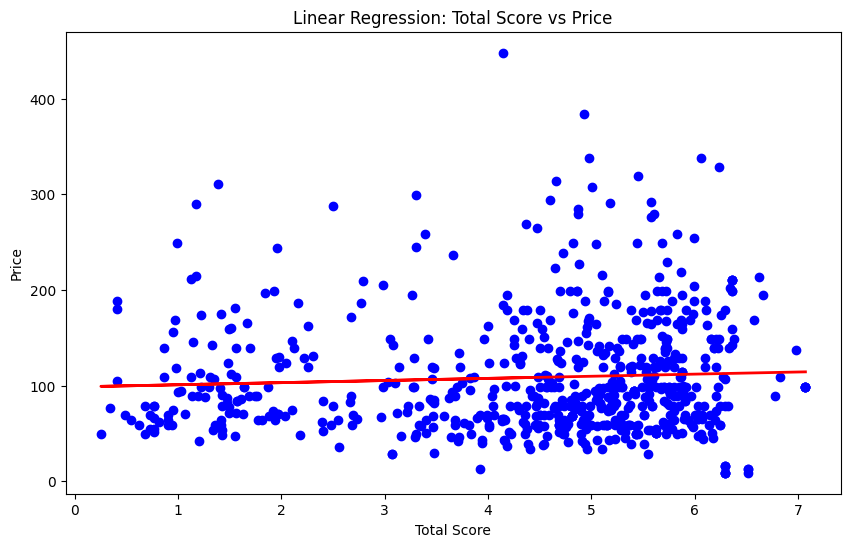

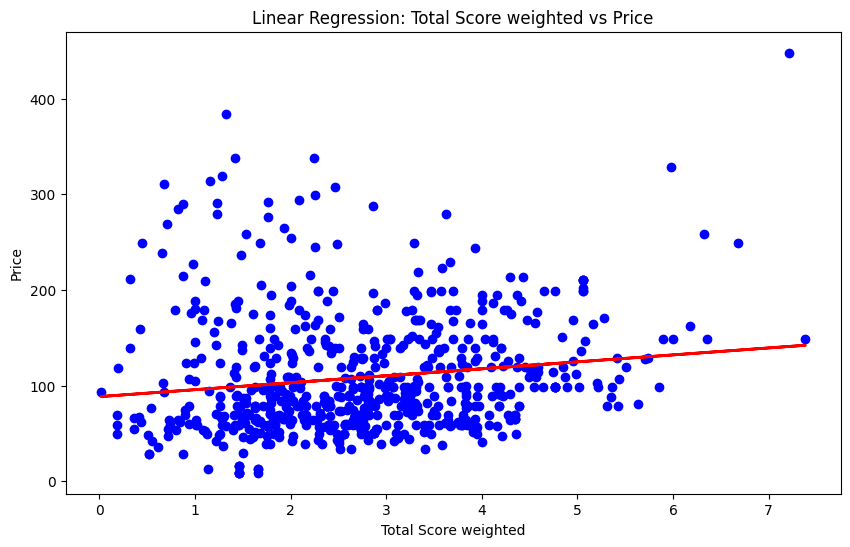

In [5]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv(r'C:\A+ Appliance Recommender\scored_data_strings_Numeric_with_weights.csv')

# Specify columns of interest
columns_of_interest = ['Total Score', 'Total Score weighted', 'Price']

# Drop rows with NaN values in the columns of interest
df_cleaned = df.dropna(subset=columns_of_interest)

# Calculate Pearson correlation coefficients
correlation_total_score = df_cleaned['Total Score'].corr(df_cleaned['Price'])
correlation_total_score_weighted = df_cleaned['Total Score weighted'].corr(df_cleaned['Price'])

print("Correlation between Total Score and Price:", correlation_total_score)
print("Correlation between Total Score weighted and Price:", correlation_total_score_weighted)

# Perform linear regression
def perform_regression(x, y):
    model = LinearRegression()
    model.fit(x.values.reshape(-1, 1), y)
    r_squared = model.score(x.values.reshape(-1, 1), y)
    return model, r_squared

# Regression for Total Score
model_total_score, r_squared_total_score = perform_regression(df_cleaned['Total Score'], df_cleaned['Price'])
print("R-squared for Total Score:", r_squared_total_score)

# Regression for Total Score weighted
model_total_score_weighted, r_squared_total_score_weighted = perform_regression(df_cleaned['Total Score weighted'], df_cleaned['Price'])
print("R-squared for Total Score weighted:", r_squared_total_score_weighted)

# Visualize the regression using matplotlib
def plot_regression(x, y, model, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color='blue')
    plt.plot(x, model.predict(x.values.reshape(-1, 1)), color='red', linewidth=2)
    plt.xlabel(x.name)
    plt.ylabel('Price')
    plt.title(title)
    plt.show()

# Plot regression for Total Score
plot_regression(df_cleaned['Total Score'], df_cleaned['Price'], model_total_score, 'Linear Regression: Total Score vs Price')

# Plot regression for Total Score weighted
plot_regression(df_cleaned['Total Score weighted'], df_cleaned['Price'], model_total_score_weighted, 'Linear Regression: Total Score weighted vs Price')


#### Streamlit Interface

Looking ahead, there is significant potential to enhance the platform by integrating Google Vision API and ChatGPT API. By incorporating Google Vision API, users could upload images of air fryers to automatically identify the model and retrieve its details. This would streamline the search process and make the platform even more user-friendly.

Additionally, integrating ChatGPT API could allow for advanced review analysis. The platform could summarize user reviews from various sources, highlighting key points and trends, such as common praises or complaints about specific features. This would provide users with a quick and comprehensive overview of what other customers are saying, helping them make more informed decisions.

In [ ]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Load the CSS file
def load_css(file_name):
    with open(file_name) as f:
        st.markdown(f'<style>{f.read()}</style>', unsafe_allow_html=True)

# Apply the CSS
load_css('styles.css')

# Rest of your Streamlit code

# Load the user's energy consumption data
user_consumption_df = pd.read_csv('User Energy Consumption.csv')

# Convert the 'Day' column to datetime
user_consumption_df['Day'] = pd.to_datetime(user_consumption_df['Day'], format='%m/%d/%Y')

# Aggregate data by month
user_consumption_df['Month'] = user_consumption_df['Day'].dt.to_period('M')
monthly_consumption_df = user_consumption_df.groupby('Month').agg({'Total consumption': 'sum'}).reset_index()

# Convert consumption to kilowatt-hours
monthly_consumption_df['Total consumption'] = monthly_consumption_df['Total consumption'] / 1000

# Rename the columns for clarity
monthly_consumption_df.columns = ['Month', 'Total consumption (kWh)']

# Convert 'Month' to string for display purposes
monthly_consumption_df['Month'] = monthly_consumption_df['Month'].dt.strftime('%B')

# Plotting function
def plot_energy_comparison(old_data, new_data, appliance_name, monthly_savings):
    plt.figure(figsize=(10, 5))
    plt.bar(old_data['Month'], old_data['Total consumption (kWh)'], color='gray', label='Current Appliance')
    plt.bar(new_data['Month'], new_data['Total consumption (kWh)'], color='orange', alpha=0.7, label='New Appliance')
    plt.xlabel('Month')
    plt.ylabel('Total Consumption (kWh)')
    plt.title('Energy Consumption Comparison')
    plt.xticks(rotation=45)
    plt.yticks(range(0, int(max(old_data['Total consumption (kWh)'].max(), new_data['Total consumption (kWh)'].max()) + 20), 20))
    plt.legend()
    st.pyplot(plt)
    st.write(f"After the payback period, you will save approximately €{monthly_savings:.2f} each month.")

# Your existing appliance recommendation code
import streamlit as st
import pandas as pd

# Load your dataset
main_df = pd.read_csv('scored_data_strings_Numeric_with_weights.csv')

# Exclude air fryers with NaN values in 'Price' and 'Suitable for number of people' columns
main_df = main_df.dropna(subset=['Price', 'Suitable for number of people'])

# Energy provider tariffs (in EUR per kWh)
energy_providers = {
    'Essent': 0.38,
    'Vattenfall': 0.33,
    'Budget Energie': 0.331,
    'Coolblue Energie': 0.246,
    'Delta Energie': 0.372,
    'Eneco': 0.304,
    'Energiedirect.nl': 0.335,
    'Engie': 0.294,
    'Greenchoice': 0.350
}

# Helper function to classify energy label
def energy_label(power):
    if 0.5 <= power < 1:
        return "A++"
    elif 1 <= power < 1.3:
        return "A+"
    elif 1.3 <= power <= 1.5:
        return "A"
    elif 1.5 < power < 2:
        return "B+"
    elif 2 <= power < 2.5:
        return "B"
    else:
        return "C"

# Helper function to calculate payback period and monthly savings after payback period
def calculate_payback_period_and_savings(price_recommendation, power_difference, tariff, usage_per_week):
    if power_difference == 0:
        return None, None, None
    weekly_savings = power_difference * usage_per_week
    monthly_savings = weekly_savings * 4  # 4 weeks in a month
    monthly_cost_savings = monthly_savings * tariff
    payback_period_months = price_recommendation / monthly_cost_savings
    years = int(payback_period_months // 12)
    months = int(payback_period_months % 12)
    return years, months, monthly_cost_savings

# Helper function to generate tags
def generate_tags(search_row, rec_row):
    tags = []
    if rec_row['Number of programs'] > search_row['Number of programs']:
        tags.append("More programs")
    if rec_row['Cord length'] > search_row['Cord length']:
        tags.append("Longer cord")
    if rec_row['Product weight'] < search_row['Product weight']:
        tags.append("Less weight")
    if rec_row['Contents'] > search_row['Contents']:
        tags.append("More capacity")
    if rec_row['Factory warranty term'] > search_row['Factory warranty term']:
        tags.append("Longer warranty")
    if rec_row['Introduction'] > search_row['Introduction']:
        tags.append("Newer")
    if rec_row['Price'] < search_row['Price']:
        tags.append("Cheaper")
    if rec_row['Power'] < search_row['Power']:
        tags.append("More energy efficient")

    # Add tags for string columns
    string_columns = ['Dishwasher safe', 'Controllable via app', 'Transparent lid', 'Warm-up function', 'Removable bowl', 'Overheat protection']
    for col in string_columns:
        if rec_row[col] == 'Ja' and (search_row[col] == 'Nee' or pd.isna(search_row[col])):
            tags.append(col)

    return tags

# Streamlit interface
st.title('A+ Appliance Recommender')

# Dropdown for selecting energy provider
energy_provider = st.selectbox('Select your energy provider', list(energy_providers.keys()))

# Dropdown for usage frequency
usage_frequency = st.selectbox('How much do you use your airfryer?', 
                               ['1-7 times a week', 'A few times a month', 'Rarely'])
usage_per_week = 3  # Default usage

if usage_frequency == '1-7 times a week':
    usage_per_week = st.slider('Select usage per week', 1, 7, 3)
elif usage_frequency == 'A few times a month':
    usage_per_week = 4
elif usage_frequency == 'Rarely':
    usage_per_week = 1

# Dynamic search bar for airfryer models
search_model = st.text_input('Search for a model')
if search_model:
    filtered_df = main_df[main_df['Model'].str.contains(search_model, case=False, na=False) & (main_df['Power'] != 0)]
    matching_models = filtered_df[['Model', 'Image']].drop_duplicates().values.tolist()
    if matching_models:
        selected_model = st.selectbox('Select a model', options=[f"{model[0]}" for model in matching_models], index=0)
        matched_airfryer = main_df[main_df['Model'] == selected_model]
        
        if not matched_airfryer.empty:
            row = matched_airfryer.iloc[0]
            
            st.subheader("Your Current Air Fryer")
            col1, col2 = st.columns([1, 3])
            with col1:
                st.image(row['Image'], width=150)
            with col2:
                st.write(f"Model: {row['Model']}")
                st.write(f"Price: ${row['Price']}")
                st.write(f"Total Score: {row['Total Score']}")
                st.write(f"Power: {row['Power']} kWh")
                energy_label_value = energy_label(row['Power'])
                st.write(f"Energy Label: {energy_label_value}")
                st.write(f"[Link to product]({row['Link']})")

            st.write("---")

            if energy_label_value in ["A++", "A+", "A"]:
                st.write("This appliance is energy efficient already. You don't need to replace it.")
            else:
                # Get recommendations based on 'suitable for number of people' and other criteria
                suitable_for = row['Suitable for number of people']
                recommendations = main_df[(main_df['Suitable for number of people'] == suitable_for) &
                                          (main_df['Model'] != row['Model']) &
                                          (main_df['Total Score'] > row['Total Score']) &
                                          (main_df['Power'] < row['Power']) &
                                          (main_df['Price'] < row['Price']) &
                                          (main_df['Power'] != 0) & (main_df['Price'] != 0)]

                recommendations = recommendations.drop_duplicates(subset=['Model']).sort_values(by=['Total Score', 'Power', 'Price'], ascending=[False, True, True]).head(3)

                if recommendations.empty:
                    # If no better products are found, recommend the closest ones
                    recommendations = main_df[(main_df['Suitable for number of people'] == suitable_for) &
                                              (main_df['Model'] != row['Model']) &
                                              (main_df['Power'] < row['Power']) &
                                              (main_df['Price'] < row['Price']) &
                                              (main_df['Power'] != 0) & (main_df['Price'] != 0)]

                    recommendations = recommendations.drop_duplicates(subset=['Model']).sort_values(by=['Total Score', 'Power', 'Price'], ascending=[False, True, True]).head(3)

                    if recommendations.empty:
                        st.write("No suitable recommendations found.")
                    else:
                        st.write("This appliance is energy efficient already. However, here are some close matches:")
                else:
                    st.write(f"Recommendations for airfryers suitable for {suitable_for} people:")

                for _, rec_row in recommendations.iterrows():
                    col1, col2 = st.columns([1, 3])
                    with col1:
                        st.image(rec_row['Image'], width=150)
                    with col2:
                        st.write(f"Model: {rec_row['Model']}")
                        st.write(f"Price: ${rec_row['Price']}")
                        st.write(f"Total Score: {rec_row['Total Score']}")
                        st.write(f"Power: {rec_row['Power']} kWh")
                        st.write(f"Energy Label: {energy_label(rec_row['Power'])}")
                        
                        # Calculate payback period and monthly savings after payback period
                        power_difference = row['Power'] - rec_row['Power']
                        tariff = energy_providers[energy_provider]
                        years, months, monthly_savings = calculate_payback_period_and_savings(rec_row['Price'], power_difference, tariff, usage_per_week)
                        if years is not None and months is not None:
                            st.write(f"Payback Period: {years} years and {months} months")
                            st.write(f"After the payback period, you will save approximately €{monthly_savings:.2f} each month.")
                        else:
                            st.write("Payback Period: Not applicable due to zero power consumption difference.")
                        st.write(f"[Link to product]({rec_row['Link']})")
                        
                        # Generate and display tags
                        tags = generate_tags(row, rec_row)
                        if tags:
                            st.write("Tags: " + ", ".join(tags))

                        # Button for comparing energy consumption with graphs
                        if st.button('Compare', key=rec_row["Model"]):
                            new_monthly_consumption_df = monthly_consumption_df.copy()
                            new_monthly_consumption_df['Total consumption (kWh)'] = (new_monthly_consumption_df['Total consumption (kWh)'] / row['Power']) * rec_row['Power']
                            
                            plot_energy_comparison(monthly_consumption_df, new_monthly_consumption_df, rec_row['Model'], monthly_savings)
else:
    st.write("No matching airfryer model found.")


#### Limitations

While the platform provides valuable features and insights for users looking to compare and choose air fryers, there are several potential limitations. The accuracy and completeness of the data are critical, as the platform's recommendations and calculations rely heavily on this information. Incomplete or outdated data could lead to incorrect recommendations and savings estimates. Additionally, the platform focuses on specific criteria such as total score, power consumption, and price. Users with different priorities, such as design, brand preference, or additional features not covered by the dataset, might find the recommendations less useful. Furthermore, the platform's effectiveness depends on the quality of user inputs, including the correct identification of the current air fryer model and accurate usage frequency.

Integrating external APIs like Google Vision and ChatGPT could introduce complexities, including potential issues related to API limits and response times. The platform uses predefined tariffs for energy cost calculations, which might not accurately reflect the user's actual energy costs if they have different providers or contracts. While the platform includes tags for certain features, there may be other important features and specifications not considered, limiting the comprehensiveness of the recommendations. Additionally, users might encounter technical issues such as slow load times or errors in data retrieval and processing. Ensuring a seamless user experience across different devices and browsers can be challenging. Finally, users might want to understand how recommendations are generated, so ensuring transparency in the algorithms used for scoring and recommending air fryers is essential to maintain user trust.

In [3]:
import pandas as pd
df = pd.read_csv('C:\A+ Appliance Recommender\scored_data_strings_Numeric_with_weights.csv')
df.head()

<>:2: SyntaxWarning: invalid escape sequence '\A'
<>:2: SyntaxWarning: invalid escape sequence '\A'
C:\Users\R.GH-SYS\AppData\Local\Temp\ipykernel_12740\2526538631.py:2: SyntaxWarning: invalid escape sequence '\A'
  df = pd.read_csv('C:\A+ Appliance Recommender\scored_data_strings_Numeric_with_weights.csv')


,Model,Total Score,Total Score weighted,Total numeric score,Total string score,Price,Image,Review Score,Reviews_dutch,Link,...,Warm-up function_score,Overheat protection,Overheat protection_score,PFAS-free,PFAS-free_score,Suitable for number of people,Optimal baking capacity,Reviews,Total numeric score.1,Total Score weighted.1
0,Zedar AF600 Airfryer XXL - Met APP - Groot 8 L...,7.071,4.769,2.495,4.576,99.0,https://media.s-bol.com/NRowkj71D3kz/vN0xzn/55...,4.6,[{'review_text': 'Top Airfryer met handige app...,https://www.bol.com/nl/nl/p/zedar-af600-airfry...,...,0.208,Ja,0.208,Ja,0.208,Meer dan 6 personen,Extra groot: meer dan 1500 gram,[{'review_text': 'Top Airfryer with handy app ...,2.495,4.769
1,Russell Hobbs Satisfry 4L Airfryer / Hetelucht...,4.802,2.384,1.474,3.328,79.0,https://media.s-bol.com/7zLk9xAv5OgQ/EMvRPk/55...,4.8,"[{'review_text': ""Geweldig voor een- of tweepe...",https://www.bol.com/nl/nl/p/airfryer-satisfry-...,...,0.208,Ja,0.208,Ja,0.208,3 tot 4 personen,Gemiddeld: 750 - 1000 gram,"[{'review_text': ""Great for one or two-person ...",1.474,2.384
2,Ninja Foodi AF300EU Dubbele Airfryer XXL - Twe...,6.363,5.054,2.411,3.952,199.0,https://media.s-bol.com/mPrEyqgNKln3/Y4VgM9/55...,4.7,[{'review_text': 'Superfijne en grote AirFryer...,https://www.bol.com/nl/nl/p/ninja-foodi-af300e...,...,0.208,Ja,0.208,Nee,0.000,NaN,NaN,[{'review_text': 'Super nice and large AirFrye...,2.411,5.054
3,Philips Airfryer Essential HD9252/90 - Heteluc...,5.585,2.820,1.633,3.952,106.0,https://media.s-bol.com/oPk19WL8LglX/JJRDyJ/55...,4.6,[{'review_text': 'Ideale compromis tussen een ...,https://www.bol.com/nl/nl/p/philips-airfryer-e...,...,0.208,Ja,0.208,Ja,0.208,3 tot 4 personen,Gemiddeld: 750 - 1000 gram,[{'review_text': 'Ideal compromise between a f...,1.633,2.820
4,Ninja Foodi Multifunctionele Airfryer - 3.8 Li...,5.417,3.285,1.881,3.536,94.0,https://media.s-bol.com/qBoMnmZx367/550x703.jpg,4.7,"[{'review_text': ""Ninja nu al onmisbaar!\nBerr...",https://www.bol.com/nl/nl/p/ninja-foodi-multif...,...,0.208,Ja,0.208,Ja,0.208,"4 tot 6 personen, Meer dan 6 personen","Extra groot: meer dan 1500 gram, Groot: 1000 -...","[{'review_text': ""Ninja is already indispensab...",1.881,3.285
